<a href="https://colab.research.google.com/github/Viraj465/CaptchaRecognitionModel/blob/main/__FinalCodeNoteBook_BreastCancerDetection__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Sep 29 15:16:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Gemini install
!pip install -q -U python-gemini-api pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00


In [3]:
import google.generativeai as genai
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

gen_model = genai.GenerativeModel('gemini-1.5-flash')

In [4]:
gen_model

genai.GenerativeModel(
    model_name='models/gemini-1.5-flash',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

In [5]:
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
import glob
import json
import requests
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = "whitegrid")
import tensorflow as tf
import tf_keras
from tf_keras.models import Sequential, Model, save_model, load_model
from tf_keras.layers import (Dense, Dropout, Activation, MaxPool2D, Flatten, Conv2D, UpSampling2D, Input,
                             Conv2DTranspose, LeakyReLU, BatchNormalization, Reshape,Input)
from tf_keras.optimizers import Adam, RMSprop
from tf_keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tf_keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tf_keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tf_keras.utils import to_categorical
from tf_keras.preprocessing.image import img_to_array, load_img
from tf_keras.activations import relu, sigmoid, tanh, softmax
from google.colab.patches import cv2_imshow
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings("ignore")

In [8]:
print('built with cuda',tf.test.is_built_with_cuda(), '\n',
'gpus available',tf.test.is_gpu_available() )
# Avoid OOM error (Out of Memory error)
gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')
print(gpus),print(cpus)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


built with cuda True 
 gpus available True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


(None, None)

In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
image_xlsx_data = r'/content/drive/MyDrive/__GENAIXCHANGE__/brest-lesion-dataset.xlsx'
image_data = r'/content/drive/MyDrive/__GENAIXCHANGE__/BrEaST-Lesions_USG-images_and_masks'
norm_image=r'/content/drive/MyDrive/__GENAIXCHANGE__/norm_grayscale_folder'
tumor_image_folder = r'/content/drive/MyDrive/__GENAIXCHANGE__/tumor_folder'
csv_data = pd.read_excel(image_xlsx_data)

In [11]:
csv_data.head()

,Image_filename,Mask_tumor_filename,thermogramImages,roiImages,Pixel_size,Age,Tissue_composition,Signs,Symptoms,Shape,Margin,Echogenicity,Posterior_features,Halo,Calcifications,Skin_thickening,Interpretation,Verification,Diagnosis,BIRADS,Classification,normal_image_path
0,case001.png,case001_tumor.png,thermogram_case001.png,output_thermogram_case001.png,0.007812,57,heterogeneous: predominantly fat,breast scar,family history of breast/ovarian cancer,irregular,not circumscribed - indistinct,heterogeneous,shadowing,no,no,yes,Breast scar (surgery)&Breast scar (radiotherapy),confirmed by follow-up care,not applicable,2,benign,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...
1,case002.png,case002_tumor.png,thermogram_case002.png,output_thermogram_case002.png,0.006462,53,homogeneous: fat,not available,not available,oval,not circumscribed - indistinct,hypoechoic,no,no,no,no,Dysplasia&Fibroadenoma,confirmed by biopsy,Intramammary lymph node,4b,benign,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...
2,case003.png,case003_tumor.png,thermogram_case003.png,output_thermogram_case003.png,0.006944,56,heterogeneous: predominantly fat,no,nipple discharge,oval,circumscribed,hyperechoic,no,no,no,no,Duct filled with thick fluid&Intraductal papil...,confirmed by biopsy,Usual ductal hyperplasia (UDH)&Pseudoangiomato...,4a,benign,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...
3,case004.png,case004_tumor.png,thermogram_case004.png,output_thermogram_case004.png,0.007812,43,homogeneous: fibroglandular,no,no,round,circumscribed,hypoechoic,no,no,no,no,Cyst filled with thick fluid,confirmed by follow-up care,not applicable,3,benign,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...
4,case005.png,case005_tumor.png,thermogram_case005.png,output_thermogram_case005.png,0.007812,67,homogeneous: fat,nipple retraction&palpable,family history of breast/ovarian cancer,oval,circumscribed,complex cystic/solid,enhancement,no,no,no,Suspicion of malignancy&Intraductal papilloma,confirmed by biopsy,Encapsulated papillary carcinoma&Ductal carcin...,4b,malignant,/content/drive/MyDrive/__GENAIXCHANGE__/norm_g...


<font color="yellow"> The color in yellow depicts features can be imp for early-stage detection</font><br>
1.   <font color="yellow">Tissue_composition</font>: This refers to the composition of tissues in the tumor region, which can help in understanding the nature of the tumor (e.g., benign vs malignant)
2.   <font color="yellow">Signs</font>: Any clinical signs (like lumps) can be relevant to **early-stage** detection
3. *Symptoms: Symptoms can give clues regarding the progression or aggressiveness of the cancer.* (need to reconsider if to keep or not)
4. <font color="yellow">Shape</font>: The shape of a tumor can be an important diagnostic feature. Irregularly shaped tumors may indicate malignancy.
5. <font color="yellow">Margin</font>: This describes the border of the tumor. A smooth margin is more likely benign, while a spiculated or irregular margin may indicate malignancy.
6. <font color="yellow">Echogenicity</font>: This refers to the ability of the tissue to reflect ultrasound waves, which can be useful in distinguishing between benign and malignant masses.
7. *Posterior_features: These features (e.g., shadowing or enhancement) provide additional clues about the type of mass*
8. *Halo: Presence or absence of a halo around the tumor may help in determining malignancy.*
9. <font color="yellow">Calcifications</font>: Microcalcifications are tiny deposits of calcium that may indicate **early-stage cancer**, especially in mammograms.*
10. <font color="yellow">Skin_thickening</font>: This can be an early sign of malignancy, particularly in breast cancer*
11. <font color="pink">BIRADS</font>: This is a standardized breast imaging reporting system used by radiologists. A lower BIRADS score indicates likely benign findings, while a higher score is more suspicious of cancer.
12. *Interpretation: The interpretation of the imaging study could provide insights into early-stage vs later-stage cancer.*
13. *Diagnosis: If available, this column could provide definitive information about whether the tumor is cancerous and its stage.*



In [13]:
csv_data.columns[4:]

Index(['Pixel_size', 'Age', 'Tissue_composition', 'Signs', 'Symptoms', 'Shape',
       'Margin', 'Echogenicity', 'Posterior_features', 'Halo',
       'Calcifications', 'Skin_thickening', 'Interpretation', 'Verification',
       'Diagnosis', 'BIRADS', 'Classification', 'normal_image_path'],
      dtype='object')

In [14]:
images = []
tumor_seg = []
for filename in os.listdir(image_data):
  if filename.endswith(".png") and not filename.endswith("_tumor.png") and not filename.endswith("_other1.png") and not filename.endswith("_other2.png") and not filename.endswith("_other3.png") and not filename.endswith("_other4.png"):
    images.append(filename)
  else:
    tumor_seg.append(filename)
images = sorted(images)
tumor_seg = sorted(tumor_seg)

In [15]:
# import shutil
# if not os.path.exists(tumor_image_folder):
#   os.makedirs(tumor_image_folder)
# for filename in tumor_seg:
#   tumor_file = os.path.join(image_data, filename)
#   output_path = os.path.join(tumor_image_folder, filename)
#   shutil.copy(tumor_file, output_path)

 **<h3>Step1:- mapping images and its label.</h1>**

In [16]:
file_path = []
label = []
for index, row in csv_data.iterrows():
  label.append(row['Classification'])
for i in images:
  file_path.append(os.path.join(image_data,i))

In [17]:
file_path[:5], label[:5]

(['/content/drive/MyDrive/__GENAIXCHANGE__/BrEaST-Lesions_USG-images_and_masks/case001.png',
  '/content/drive/MyDrive/__GENAIXCHANGE__/BrEaST-Lesions_USG-images_and_masks/case002.png',
  '/content/drive/MyDrive/__GENAIXCHANGE__/BrEaST-Lesions_USG-images_and_masks/case003.png',
  '/content/drive/MyDrive/__GENAIXCHANGE__/BrEaST-Lesions_USG-images_and_masks/case004.png',
  '/content/drive/MyDrive/__GENAIXCHANGE__/BrEaST-Lesions_USG-images_and_masks/case005.png'],
 ['benign', 'benign', 'benign', 'benign', 'malignant'])

<h3>Step2: Model processing</h3>

In [18]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNEL = 1 # most important part
latent_dim = 128
input_shape = (IMG_HEIGHT, IMG_WIDTH,CHANNEL)
batch_size = 16
lr = 1e-3

In [19]:
images = []
masks = []

for img_name in sorted(os.listdir(norm_image)):
    img_path = os.path.join(norm_image, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    images.append(img)

for img_name in sorted(os.listdir(norm_image)):
    current_masks = []

    mask_files = [
        img_name.replace('.png', '_tumor.png'),
        img_name.replace('.png', '_other1.png'),
        img_name.replace('.png', '_other2.png'),
        img_name.replace('.png', '_other3.png'),
        img_name.replace('.png', '_other4.png')
    ]

    for mask_name in mask_files:
        mask_path = os.path.join(tumor_image_folder, mask_name)

        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (224, 224))
            mask = mask / 255.0
            current_masks.append(mask)


    if current_masks:
        stacked_masks = np.stack(current_masks, axis=-1)
        masks.append(stacked_masks)
    else:
        masks.append(np.zeros((224, 224, 1)))

In [20]:
images[:5]

[array([[0.49019608, 0.55294118, 0.58823529, ..., 0.62352941, 0.59607843,
         0.61568627],
        [0.23921569, 0.24705882, 0.34901961, ..., 0.4745098 , 0.40392157,
         0.37254902],
        [0.34509804, 0.37254902, 0.40392157, ..., 0.36470588, 0.30588235,
         0.31372549],
        ...,
        [0.30588235, 0.30588235, 0.28627451, ..., 0.36078431, 0.36862745,
         0.35686275],
        [0.29411765, 0.31764706, 0.32156863, ..., 0.37254902, 0.36078431,
         0.34901961],
        [0.28235294, 0.29803922, 0.31764706, ..., 0.51372549, 0.50588235,
         0.49411765]]),
 array([[0.64313725, 0.62352941, 0.63921569, ..., 0.59215686, 0.52156863,
         0.59215686],
        [0.55686275, 0.51764706, 0.54901961, ..., 0.70196078, 0.7254902 ,
         0.74901961],
        [0.84705882, 0.81176471, 0.78039216, ..., 0.94901961, 0.9254902 ,
         0.87058824],
        ...,
        [0.24313725, 0.18431373, 0.20784314, ..., 0.41176471, 0.45098039,
         0.4627451 ],
        [0.2

In [21]:
masks[:5]

[array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]),
 array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
       

In [22]:
images = np.array(images)
images = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, CHANNEL)
images.shape

(256, 224, 224, 1)

In [24]:
# masks = np.array(masks, dtype=object)
# masks_shp = np.stack([np.atleast_3d(m) for m in masks], axis=0)
# masks_shp.shape

ValueError: could not broadcast input array from shape (224,224,1) into shape (224,224)

In [91]:
# images = np.expand_dims(images, axis=-1)
# masks = np.expand_dims(masks, axis=-1)

In [26]:
gen_cols = ['Tissue_composition', 'Signs', 'Shape', 'Margin', 'Echogenicity', 'Calcifications']
categorical_cols = ['Tissue_composition', 'Signs', 'Symptoms', 'Shape', 'Margin',
                    'Echogenicity', 'Posterior_features', 'Halo', 'Calcifications',
                    'Skin_thickening', 'Interpretation', 'Verification']
numerical_cols = ['Age','Pixel_size']

In [27]:
# csv_data_encoded = pd.get_dummies(csv_data, columns=categorical_cols)
# csv_data['normal_image_path'] = csv_data['Image_filename'].apply(lambda x: os.path.join(norm_image, x))

In [28]:
# csv_data['tumor_image_path'] = csv_data['Mask_tumor_filename'].apply(lambda x: os.path.join(tumor_image_folder, x))

**<font color="orange">CAE Model</font>**

In [35]:
input_shape = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))
# Encoder
x = input_shape
print(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)  # 112

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)  # 56

x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)  # 28

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2, 2))(x)  # 14

x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
encoded = MaxPool2D((2, 2))(x)  # 7
print(encoded)
x = Flatten()(encoded)
units = x.shape[1]
latent_dim = 10
latent = Dense(latent_dim, name='Latent')(x)

# Decoder
x = Dense(units)(latent)
x = LeakyReLU(alpha=0.2)(x)
x = Reshape((7, 7, 512))(x)

x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('sigmoid')(x)
decoded = Conv2DTranspose(CHANNEL, (3, 3), strides=(1, 1), padding='same')(x)

outputs = decoded
print(outputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='max_pooling2d_9/MaxPool:0', description="created by layer 'max_pooling2d_9'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), name='conv2d_transpose_11/BiasAdd:0', description="created by layer 'conv2d_transpose_11'")


In [36]:
autoencoder = Model(input_shape, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [39]:
from tf_keras.utils import plot_model
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 batch_normalization_10 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      1849

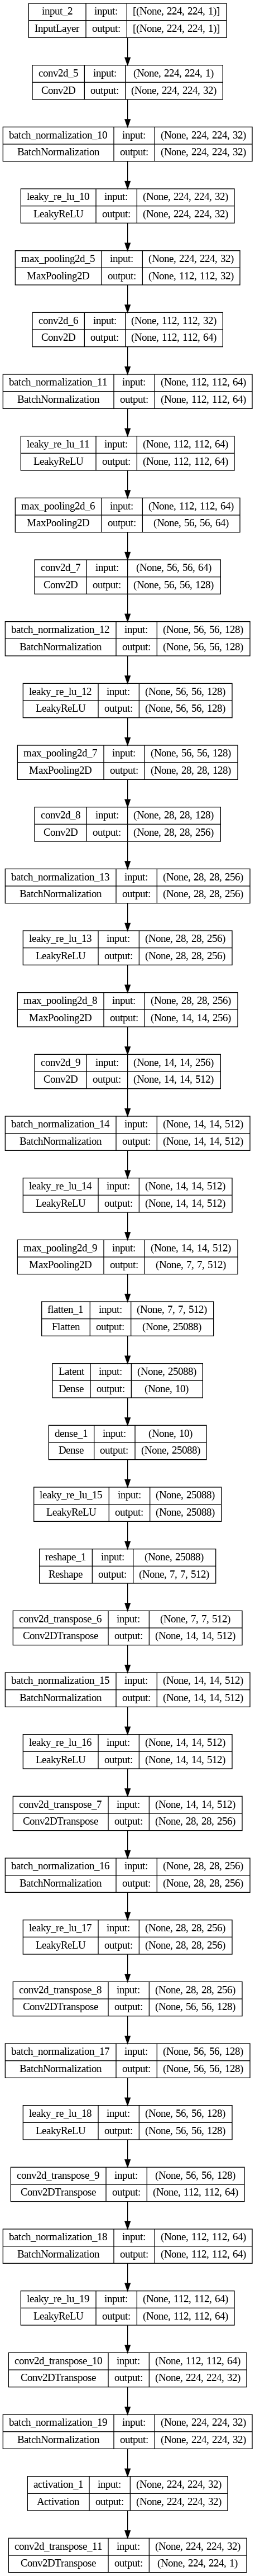

In [40]:
plot_model(autoencoder, to_file='autoencoder_summary.png', show_shapes=True)

In [41]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint(filepath='/content/drive/MyDrive/__GENAIXCHANGE__/autoencoder_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

In [43]:
autoencoder.fit(images,images, epochs=100, batch_size=batch_size, validation_split=0.1,verbose = 2, callbacks = callbacks)

Epoch 1/100

Epoch 1: val_loss improved from inf to 0.56487, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/autoencoder_model.h5
15/15 - 3s - loss: 0.5416 - val_loss: 0.5649 - lr: 0.0010 - 3s/epoch - 220ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.56487 to 0.56196, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/autoencoder_model.h5
15/15 - 2s - loss: 0.5417 - val_loss: 0.5620 - lr: 0.0010 - 2s/epoch - 150ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.56196
15/15 - 2s - loss: 0.5437 - val_loss: 0.5621 - lr: 0.0010 - 2s/epoch - 114ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.56196 to 0.56190, saving model to /content/drive/MyDrive/__GENAIXCHANGE__/autoencoder_model.h5
15/15 - 2s - loss: 0.5413 - val_loss: 0.5619 - lr: 0.0010 - 2s/epoch - 132ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.56190
15/15 - 2s - loss: 0.5398 - val_loss: 0.5638 - lr: 0.0010 - 2s/epoch - 110ms/step
Epoch 6/100

Epoch 6: val_loss improved from 0.5

In [44]:
trained_encoder = Model(input_shape, encoded)
image_features = trained_encoder.predict(images)

8/8 [==============================] - 1s 22ms/step


In [45]:
image_features

array([[[[-1.46218225e-01, -1.75476119e-01, -1.31173506e-01, ...,
          -7.28318319e-02,  1.49196434e+00,  1.82152426e+00],
         [-1.15744628e-01, -1.71232224e-01, -1.15261339e-01, ...,
          -6.54766290e-03,  1.45253527e+00,  1.24627459e+00],
         [-8.58270302e-02, -1.38532445e-01, -1.04352035e-01, ...,
           1.67066231e-01,  1.11561632e+00,  1.29879332e+00],
         ...,
         [ 4.95619029e-01,  2.04906985e-01, -3.97236273e-02, ...,
           1.39447844e+00, -2.84879599e-02, -1.39889047e-02],
         [-6.61406666e-02, -9.42080170e-02, -1.19238749e-01, ...,
           8.12476397e-01,  6.44739151e-01,  2.37351799e+00],
         [-1.09871387e-01, -1.80670545e-01, -1.07637338e-01, ...,
          -1.12901390e-01,  1.81596112e+00,  2.07253075e+00]],

        [[-2.87331164e-01, -2.92525947e-01, -2.40800977e-01, ...,
          -3.01141351e-01,  2.95488572e+00,  3.25240397e+00],
         [-2.64083922e-01, -2.72885472e-01, -2.56423205e-01, ...,
          -3.09813112e

**<font color="orange"> SegNet</font>**

In [48]:
def build_segnet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(inputs)
    x = MaxPool2D((2, 2), padding='same')(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation=tf_keras.layers.LeakyReLU(alpha=0.02), padding='same')(x)

    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    return model

In [49]:
segnet = build_segnet((IMG_HEIGHT, IMG_WIDTH, CHANNEL))

In [50]:
segnet.compile(optimizer='adam', loss='binary_crossentropy')

In [53]:
print(images.shape)
# print(masks.shape)

(256, 224, 224, 1)


In [51]:
segnet.fit(images, masks, epochs=50, batch_size=32, validation_split=0.1)

ValueError: Data cardinality is ambiguous:
  x sizes: 230
  y sizes: 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224
Make sure all arrays contain the same number of samples.

In [ ]:

# Predict mask
predicted_masks = segnet.predict(images)

In [56]:
0
def cae_model(input_shape,latent_dim):
    inputs = Input(shape = input_shape)
  # Encode
    x = inputs
    x = Conv2D(512,(3,3),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D((2,2))(x) #112

    x = Conv2D(256,(3,3),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D((2,2))(x) #56

    x = Conv2D(128,(3,3),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D((2,2))(x) #28

    x = Conv2D(64,(3,3),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D((2,2))(x) #14

    x = Conv2D(32,(3,3),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPool2D((2,2))(x) #7

    x = Flatten()(x)
    units = x.shape[1]
    latent = Dense(latent_dim, name='Latent')(x)
    print(latent)
  #Decoder
    x = Dense(units)(latent)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Reshape((7,7,32))(x)

    x = Conv2DTranspose(32,(4,4),strides = (2,2), padding ="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(64,(4,4),strides = (2,2), padding ="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(128,(4,4),strides = (2,2), padding ="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(256,(4,4),strides = (2,2), padding ="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2DTranspose(512,(4,4),strides = (2,2), padding ="same")(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    outputs = x
    print(outputs)

    return Model(inputs, outputs, name = "CAE"), Model(inputs, latent, name='Encoder')

In [57]:
cae_model(input_shape,latent_dim)

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='Latent/BiasAdd:0', description="created by layer 'Latent'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 512), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


(<tf_keras.src.engine.functional.Functional at 0x7c32984dc940>,
 <tf_keras.src.engine.functional.Functional at 0x7c3298533430>)

In [52]:
def segNet_model(input_shape):
    inputs = Input(shape = input_shape)
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = LeakyReLU(alpha = 0.2)(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = MaxPool2D((2, 2), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3),padding='same')(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = UpSampling2D((2, 2))(x)
    outputs = Conv2D(3, (1, 1), activation='softmax')(x)
    return Model(inputs, outputs, name='SegNet')

In [55]:
cae, encoder = cae_model(input_shape, latent_dim)

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='Latent/BiasAdd:0', description="created by layer 'Latent'")


In [56]:
segnet = segNet_model(input_shape)

In [58]:
input_img = Input(shape=input_shape)
encoded_features = encoder(input_img)

encoded_features = Reshape((1,1))(encoded_features)

encoded_features = tf_keras.layers.UpSampling2D(size=(224, 224))(encoded_features)
concatenated = tf_keras.layers.concatenate([input_img, encoded_features], axis=3)
segmentation_output = segnet(concatenated)

parallel_model = Model(inputs=input_img, outputs=segmentation_output)

ValueError: Exception encountered when calling layer "reshape_5" (type Reshape).

total size of new array must be unchanged, input_shape = [128], output_shape = [1, 1]

Call arguments received by layer "reshape_5" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 128), dtype=float32)

input_shape = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))
# Encoder
x = input_shape
x = Conv2D(32,(3,3),padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2,2))(x) #112

x = Conv2D(64,(3,3),padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2,2))(x) #56

x = Conv2D(128,(3,3),padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2,2))(x) #28

x = Conv2D(256,(3,3),padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPool2D((2,2))(x) #14

x = Conv2D(512,(3,3),padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
encoded = MaxPool2D((2,2))(x) #7
# print(encoded)

x = Flatten()(encoded)
units = x.shape[1]
latent_dim = 10
latent = Dense(latent_dim, name='Latent')(x)
# print(latent)

# Decoder

x = Dense(units)(latent)
x = LeakyReLU(alpha = 0.2)(x)
x = Reshape((7,7,512))(x)

x = Conv2DTranspose(512,(4,4),strides = (2,2), padding ="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(256,(4,4),strides = (2,2), padding ="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(128,(4,4),strides = (2,2), padding ="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(64,(4,4),strides = (2,2), padding ="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(32,(4,4),strides = (2,2), padding ="same")(x)
x = BatchNormalization()(x)
x = Activation('sigmoid')(x)
decoded = Conv2DTranspose(CHANNEL,(4,4),strides = (2,2), padding ="same")(x)

outputs = decoded
# print(outputs)